In [1]:
import tensorflow as tf
import adanet
import matplotlib.pyplot as plt
import numpy as np
import functools

In [2]:
# Load dataset
(x_train, labels_train), (x_test, labels_test) = tf.keras.datasets.cifar10.load_data()

print(f'x_train shape: {x_train.shape}')
print(f'labels_train shape: {labels_train.shape}')
print(f'x_test  shape: {x_test.shape}')
print(f'labels_test  shape: {labels_test.shape}')

x_train shape: (50000, 32, 32, 3)
labels_train shape: (50000, 1)
x_test  shape: (10000, 32, 32, 3)
labels_test  shape: (10000, 1)


In [3]:
x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

labels_train = labels_train.astype(np.int32)
labels_test = labels_test.astype(np.int32)

In [4]:
def show_images(rows=5, columns=5):
    """Prints a set of images."""

    for i in range(columns):
        for j in range(rows):
            index = j * columns + i + 1
            plt.subplot(rows, columns, index)
            plt.imshow(x_train[index-1])
    plt.show()

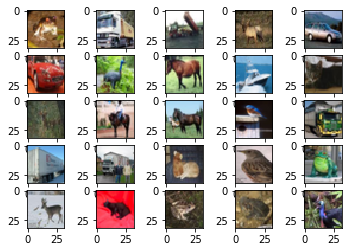

In [5]:
show_images()

In [6]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train},
    y=labels_train,
    batch_size=32,
    num_epochs=10,
    shuffle=False)

adanet_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train},
    y=labels_train,
    batch_size=32,
    num_epochs=1,
    shuffle=False)

test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_test},
    y=labels_test,
    batch_size=32,
    num_epochs=1,
    shuffle=False)

In [7]:
def cnn_model(features, labels, mode, params):
    images = list(features.values())[0]
    
    x = tf.keras.layers.Conv2D(32, kernel_size=7, activation='relu')(images)
    x = tf.keras.layers.MaxPooling2D(strides=2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    logits = tf.keras.layers.Dense(10)(x)

    # Compute predictions.
    predicted_classes = tf.argmax(logits, 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits),
            'logits': logits,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Compute loss.
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   name='acc_op')
    metrics = {'accuracy': accuracy}
    tf.summary.scalar('accuracy', accuracy[1])

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)

    # Create training op.
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001, decay=0.0)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [8]:
classifier = tf.estimator.Estimator(model_fn=cnn_model)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3khkppct', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7e8fdb1a20>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [9]:
results, _ = tf.estimator.train_and_evaluate(
    classifier,
    train_spec=tf.estimator.TrainSpec(
        input_fn=train_input_fn,
        max_steps=15625),
    eval_spec=tf.estimator.EvalSpec(
        input_fn=test_input_fn,
        steps=None))

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp3khkppct/model.ckpt.
INFO:tensorflow:loss = 2.342123, step = 1
INFO:tensorflow:global_step/sec: 28.0451
INFO:tensorf

INFO:tensorflow:loss = 5.4960527, step = 6601 (3.544 sec)
INFO:tensorflow:global_step/sec: 28.1898
INFO:tensorflow:loss = 3.9388375, step = 6701 (3.548 sec)
INFO:tensorflow:global_step/sec: 28.4397
INFO:tensorflow:loss = 3.4321485, step = 6801 (3.518 sec)
INFO:tensorflow:global_step/sec: 28.3952
INFO:tensorflow:loss = 2.0294201, step = 6901 (3.520 sec)
INFO:tensorflow:global_step/sec: 28.0997
INFO:tensorflow:loss = 3.0547125, step = 7001 (3.559 sec)
INFO:tensorflow:global_step/sec: 27.3942
INFO:tensorflow:loss = 4.8417406, step = 7101 (3.651 sec)
INFO:tensorflow:global_step/sec: 27.1607
INFO:tensorflow:loss = 2.5860443, step = 7201 (3.682 sec)
INFO:tensorflow:global_step/sec: 28.2346
INFO:tensorflow:loss = 3.7086096, step = 7301 (3.542 sec)
INFO:tensorflow:global_step/sec: 27.3267
INFO:tensorflow:loss = 2.990093, step = 7401 (3.659 sec)
INFO:tensorflow:global_step/sec: 28.2745
INFO:tensorflow:loss = 2.7397811, step = 7501 (3.539 sec)
INFO:tensorflow:global_step/sec: 28.321
INFO:tensorf

INFO:tensorflow:global_step/sec: 28.6057
INFO:tensorflow:loss = 2.4937563, step = 14901 (3.496 sec)
INFO:tensorflow:global_step/sec: 28.5515
INFO:tensorflow:loss = 1.6975086, step = 15001 (3.502 sec)
INFO:tensorflow:global_step/sec: 28.3951
INFO:tensorflow:loss = 3.0609417, step = 15101 (3.522 sec)
INFO:tensorflow:global_step/sec: 28.6106
INFO:tensorflow:loss = 3.5806704, step = 15201 (3.497 sec)
INFO:tensorflow:global_step/sec: 28.4182
INFO:tensorflow:loss = 3.5339627, step = 15301 (3.519 sec)
INFO:tensorflow:global_step/sec: 28.5692
INFO:tensorflow:loss = 6.3411703, step = 15401 (3.500 sec)
INFO:tensorflow:global_step/sec: 28.4819
INFO:tensorflow:loss = 1.5361319, step = 15501 (3.510 sec)
INFO:tensorflow:global_step/sec: 28.2596
INFO:tensorflow:loss = 1.6681727, step = 15601 (3.540 sec)
INFO:tensorflow:Saving checkpoints for 15625 into /tmp/tmp3khkppct/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-0

In [10]:
print("Accuracy:", results["accuracy"])
print("Loss:", results["loss"])

Accuracy: 0.4393
Loss: 2.4009476


In [11]:
class CNNBuilder(adanet.subnetwork.Builder):
    def __init__(self, learning_rate, n_convs, seed):
        self._learning_rate = learning_rate
        self._n_convs = n_convs
        self._seed = seed
        
    def build_subnetwork(self,
                         features,
                         logits_dimension,
                         training,
                         iteration_step,
                         summary,
                         previous_ensemble=None):
        """See `adanet.subnetwork.Builder`."""
        images = list(features.values())[0]
    
        for i in range(self._n_convs):
            x = tf.keras.layers.Conv2D(32, kernel_size=7, activation='relu')(images)
            x = tf.keras.layers.MaxPooling2D(strides=2)(x)
        
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(100, activation='relu')(x)
        
        logits = tf.keras.layers.Dense(10)(x)

        # Use a constant complexity measure, since all subnetworks have the same
        # architecture and hyperparameters.
        complexity = tf.constant(1)

        persisted_tensors = {'n_convs': tf.constant(self._n_convs)}
        
        return adanet.Subnetwork(
            last_layer=x,
            logits=logits,
            complexity=complexity,
            persisted_tensors=persisted_tensors)
    
    def build_subnetwork_train_op(self,
                                subnetwork,
                                loss,
                                var_list,
                                labels,
                                iteration_step,
                                summary,
                                    previous_ensemble=None):
        """See `adanet.subnetwork.Builder`."""

        optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001, decay=0.0)
        # NOTE: The `adanet.Estimator` increments the global step.
        return optimizer.minimize(loss=loss, var_list=var_list)

    def build_mixture_weights_train_op(self, loss, var_list, logits, labels,
                                     iteration_step, summary):
        """See `adanet.subnetwork.Builder`."""
        return tf.no_op("mixture_weights_train_op")

    @property
    def name(self):
        """See `adanet.subnetwork.Builder`."""
        return f'simple_cnn_{self._n_convs}'

In [12]:
class SimpleCNNGenerator(adanet.subnetwork.Generator):
    """Generates a `SimpleCNN` at each iteration.
    """

    def __init__(self, learning_rate, seed=None):
        """Initializes a `Generator` that builds `SimpleCNNs`.

        Args:
          learning_rate: The float learning rate to use.
          max_iteration_steps: The number of steps per iteration.
          seed: The random seed.

        Returns:
          An instance of `Generator`.
        """
        self._seed = seed
        self._cnn_builder_fn = functools.partial(
            CNNBuilder,
            learning_rate=learning_rate)

    def generate_candidates(self, previous_ensemble, iteration_number,
                          previous_ensemble_reports, all_reports):
        """See `adanet.subnetwork.Generator`."""
        n_convs = 1
        seed = self._seed
        if previous_ensemble:
            n_convs = tf.contrib.util.constant_value(
                previous_ensemble.weighted_subnetworks[
                    -1].subnetwork.persisted_tensors['n_convs'])
        return [
            self._cnn_builder_fn(n_convs=n_convs, seed=seed),
            self._cnn_builder_fn(n_convs=n_convs + 1, seed=seed),
        ]

In [13]:
head = tf.contrib.estimator.multi_class_head(10)

In [14]:
TRAIN_STEPS = 15625
ADANET_STEPS = 2

max_iteration_steps = TRAIN_STEPS // ADANET_STEPS

In [15]:
estimator = adanet.Estimator(
    head=head,
    subnetwork_generator=SimpleCNNGenerator(
        learning_rate=0.001,
        seed=42),
    max_iteration_steps=max_iteration_steps,
    evaluator=adanet.Evaluator(
        input_fn=adanet_input_fn,
        steps=None),
    adanet_loss_decay=.99)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp6x8szp3y', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7e74591048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [16]:
results, _ = tf.estimator.train_and_evaluate(
    estimator,
    train_spec=tf.estimator.TrainSpec(
        input_fn=train_input_fn,
        max_steps=TRAIN_STEPS),
    eval_spec=tf.estimator.EvalSpec(
        input_fn=test_input_fn,
        steps=None))


INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Beginning training AdaNet iteration 0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Building iteration 0
INFO:tensorflow:Building subnetwork 'simple_cnn_1'
Instructions for updating:
`persisted_tensors` is deprecated, please use `shared` instead.
INFO:tensorflow:Building subnetwork 'simple_cnn_2'
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp6x8szp3y/model.ckpt.
INFO:tensorflow:loss = 2.2802377, step = 1
INFO:tensorflow:g

INFO:tensorflow:loss = 1.8563521, step = 7201 (6.840 sec)
INFO:tensorflow:global_step/sec: 14.3541
INFO:tensorflow:loss = 1.7891228, step = 7301 (6.968 sec)
INFO:tensorflow:global_step/sec: 14.629
INFO:tensorflow:loss = 2.0790453, step = 7401 (6.835 sec)
INFO:tensorflow:global_step/sec: 14.2426
INFO:tensorflow:loss = 1.6785697, step = 7501 (7.022 sec)
INFO:tensorflow:global_step/sec: 14.6237
INFO:tensorflow:loss = 1.7428341, step = 7601 (6.837 sec)
INFO:tensorflow:global_step/sec: 14.6411
INFO:tensorflow:loss = 1.4385531, step = 7701 (6.830 sec)
INFO:tensorflow:global_step/sec: 14.3984
INFO:tensorflow:loss = 1.1960771, step = 7801 (6.945 sec)
INFO:tensorflow:Saving checkpoints for 7812 into /tmp/tmp6x8szp3y/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Building iteration 0
INFO:tensorflow:Building subnetwork 'simple_cnn_1'
INFO:tensorflow:Building subnetwork 'simple_cnn_2'
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-03-02:03:41


INFO:tensorflow:global_step/sec: 11.7025
INFO:tensorflow:loss = 1.2317684, step = 8713 (8.545 sec)
INFO:tensorflow:global_step/sec: 11.9396
INFO:tensorflow:loss = 1.3422595, step = 8813 (8.374 sec)
INFO:tensorflow:global_step/sec: 11.7699
INFO:tensorflow:loss = 1.469748, step = 8913 (8.498 sec)
INFO:tensorflow:global_step/sec: 11.9676
INFO:tensorflow:loss = 1.3214495, step = 9013 (8.354 sec)
INFO:tensorflow:global_step/sec: 11.7873
INFO:tensorflow:loss = 1.2041653, step = 9113 (8.486 sec)
INFO:tensorflow:global_step/sec: 11.573
INFO:tensorflow:loss = 1.3067678, step = 9213 (8.641 sec)
INFO:tensorflow:global_step/sec: 11.7601
INFO:tensorflow:loss = 1.9672225, step = 9313 (8.502 sec)
INFO:tensorflow:global_step/sec: 11.8156
INFO:tensorflow:loss = 1.3750994, step = 9413 (8.463 sec)
INFO:tensorflow:global_step/sec: 11.6464
INFO:tensorflow:loss = 1.2398734, step = 9513 (8.586 sec)
INFO:tensorflow:global_step/sec: 11.8957
INFO:tensorflow:loss = 1.5008575, step = 9613 (8.407 sec)
INFO:tensorf

INFO:tensorflow:Saving candidate 't1_simple_cnn_2' dict for global step 14879: accuracy/adanet/adanet_weighted_ensemble = 0.4377, accuracy/adanet/subnetwork = 0.3879, accuracy/adanet/uniform_average_ensemble = 0.4377, architecture/adanet/ensembles = b'\nr\n?adanet/iteration_1/ensemble_t1_simple_cnn_2/architecture/adanetB%\x08\x07\x12\x00B\x1f| simple_cnn_1 | simple_cnn_2 |J\x08\n\x06\n\x04text', average_loss/adanet/adanet_weighted_ensemble = 1.9495832, average_loss/adanet/subnetwork = 2.7510476, average_loss/adanet/uniform_average_ensemble = 1.9495832, loss/adanet/adanet_weighted_ensemble = 1.9490522, loss/adanet/subnetwork = 2.750959, loss/adanet/uniform_average_ensemble = 1.9490522
INFO:tensorflow:Finished evaluation at 2018-12-03-02:15:13
INFO:tensorflow:Saving dict for global step 14879: accuracy = 0.4701, accuracy/adanet/adanet_weighted_ensemble = 0.4701, accuracy/adanet/subnetwork = 0.4701, accuracy/adanet/uniform_average_ensemble = 0.4701, average_loss = 1.7330108, average_loss/

INFO:tensorflow:Warm-starting variable: adanet/iteration_0/ensemble_t0_simple_cnn_1/weighted_subnetwork_0/logits/mixture_weight; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: adanet/iteration_0/ensemble_t0_simple_cnn_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: adanet/iteration_0/candidate_t0_simple_cnn_1/adanet_loss; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: adanet/iteration_0/candidate_t0_simple_cnn_1/adanet/iteration_0/candidate_t0_simple_cnn_1/adanet_loss/biased; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: adanet/iteration_0/candidate_t0_simple_cnn_1/adanet/iteration_0/candidate_t0_simple_cnn_1/adanet_loss/local_step; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: adanet/iteration_0/train_op/is_over/is_over_var_fn/is_over_var; prev_var_name: Unchanged
INFO:tensorflow:Building iteration 2
INFO:tensorflow:Building subnetwork 'simple_cnn_1'
INFO:tensorflow:Building subnetwork '

In [17]:
def ensemble_architecture(result):
    """Extracts the ensemble architecture from evaluation results."""

    architecture = result["architecture/adanet/ensembles"]
    # The architecture is a serialized Summary proto for TensorBoard.
    summary_proto = tf.summary.Summary.FromString(architecture)
    return summary_proto.value[0].tensor.string_val[0]

In [18]:
print("Accuracy:", results["accuracy"])
print("Loss:", results["average_loss"])
print(ensemble_architecture(results))

Accuracy: 0.4026
Loss: 1.6434369
b'| simple_cnn_1 | simple_cnn_2 |'
